<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1>Data Augmentation </h1> 


<h2>Table of Contents</h2>

In this lab, we train a Convolutional Neural Network with Regular data and Augmented data. The purpose of this lab is to show that the Augmented data improves generalization performance.

Think of a scenario where a drone has to take a picture of an object. The drone is moving and the object can also possibly be moving. When an image is taken we arent always going to get perfect images. The subject may not be perfectly centered in the image or the subject may be rotated in the image. In this case, a model trained on perfectly centered or rotated images won't perform well. This is why we train a model on rotated data so it can perform well on imperfect images.

In this assignment, we will use a dataset of digit images. We will have two models one trained on non rotated digits and one trained on rotated images and then we will test the models on a rotated testing dataset which will be more realistic and robust in terms of our scenario above.

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#R_training_data">Rotated Training Data</a></li>

</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>


<h2>Preparation</h2>


In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
# Download a Pretrained Model because training takes a long time
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt

--2023-08-25 15:57:45--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75134 (73K) [application/octet-stream]
Saving to: ‘normal.pt’

normal.pt           100%[===================>]  73.37K  --.-KB/s    in 0.002s  

2023-08-25 15:57:46 (37.6 MB/s) - ‘normal.pt’ saved [75134/75134]



In [3]:
# Download a Pretrained Model Trained on Augmented Data because training takes a long time
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt

--2023-08-25 15:57:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75134 (73K) [application/octet-stream]
Saving to: ‘rotated_data.pt’

rotated_data.pt     100%[===================>]  73.37K  --.-KB/s    in 0.001s  

2023-08-25 15:57:51 (50.4 MB/s) - ‘rotated_data.pt’ saved [75134/75134]



In [4]:
# Library to Show Images
!pip install Pillow==6.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.1.0
    Uninstalling Pillow-8.1.0:
      Successfully uninstalled Pillow-8.1.0


***Restart the kernel***


In [5]:
# Import the libraries we need to use in this lab
# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch 
# PyTorch Neural Network Library
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
# Allows us to download the dataset
import torchvision.datasets as dsets
# Allows us to access the filesystem
import os  

Some useful functions for plotting 


Plot Cost and Accuracy vs Epoch Graph


In [6]:
def plot_cost_accuracy(checkpoint):

# Plot the cost and accuracy

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

Define the function <code>show_data</code> to plot out data samples as images.


In [7]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

Plot first 5 misclassified samples 


In [8]:
def plot_mis_classified(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break 

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Load Data</h2> 


We create a transform object  <code>compose</code> one will resize the image and convert it to a tensor, the second will also rotate the image Randomly rotate the image.


In [9]:
# Size of the images are 16 by 16
IMAGE_SIZE = 16

# Creating a group of transformations to created a rotated dataset
# Resizes the images, randomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.RandomAffine(45), transforms.ToTensor()])

# Creating a group of transformations to created a non rotated dataset
# Resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train</code> to <code>True</code>. We use the transform defined above, one with rotated data one without.


In [10]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

Load the testing dataset by setting the parameters train to <code>False</code>, where the data is <b>ALL</b> rotated.


In [11]:
# Load the testing dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=compose_rotate)

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


Plot the first sample 


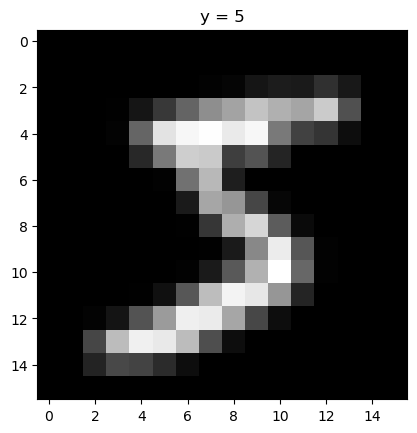

In [12]:
# The image for the first data sample
show_data(train_dataset[0])

Print out the first label, as we can see this digit is a five


In [13]:
# The label for the first data element
train_dataset[0][1]

5

Now let's plot the first sample of the rotated training dataset


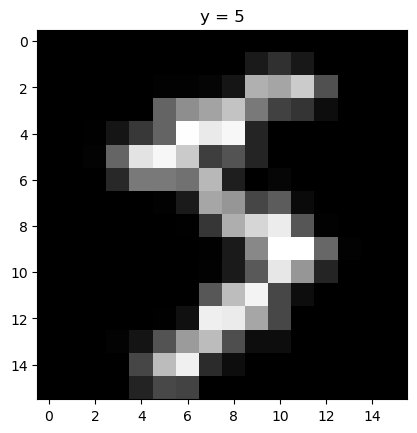

In [14]:
show_data(train_dataset_rotate[0])

We can see that this is the same sample but it is rotated as we wanted


<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layers.


In [15]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

<h2 id="regular_data">Regular Data</h2> 


Define the Convolutional Neural Network Classifier, Criterion function, Optimizer, and Train the Model


In [16]:
# Create the model object to be trained on regular data using CNN class
model = CNN(out_1=16, out_2=32)

Define the loss function, the optimizer, and the dataset loader 


In [17]:
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

This cell will train the model, we will comment it out as it takes a long time to run. You can change the block type from Raw to Code and run it or you can load the trained model in the next cell. Notice that we are not only training and saving the model here but we are also keeping track of important data like the cost and accuracy throughout the training process.


<h3 id="Result">Analyze Results</h3> 


Loads the data which is saved in `normal.pt`


In [18]:
checkpoint_normal = torch.load(os.path.join(os.getcwd(),'normal.pt'))

Plot Accuracy and Cost vs Epoch Graph


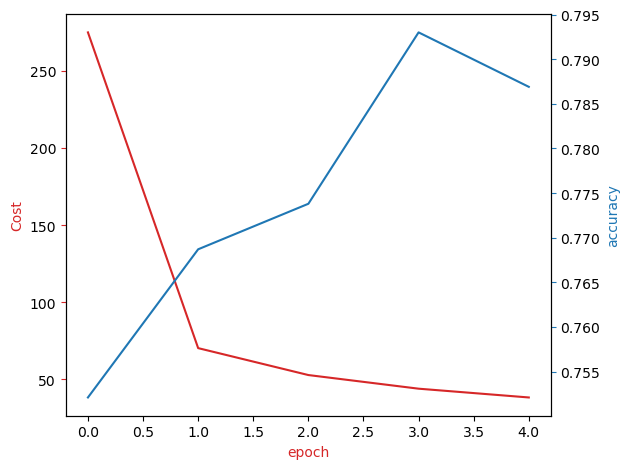

In [19]:
# Using the helper function defined at the top and the cost and accuracy lists that we saved
plot_cost_accuracy(checkpoint_normal)

Five misclassified samples


In [ ]:
# Using the model parameters we saved we load them into a model to recreate the trained model
model.load_state_dict(checkpoint_normal['model_state_dict'])
# Setting the model to evaluation mode
model.eval()
# Using the helper function plot the first five misclassified samples
plot_mis_classified(model,validation_dataset)

<!--Empty Space for separating topics-->


<h2 id="R_training_data">Rotated Training Data</h2> 


Plot the loss and accuracy on the validation data:


In [ ]:
# Create the model object using CNN class
model_r = CNN(out_1=16, out_2=32)
# We create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)
# Create a Data Loader for the rotated training data with a batch size of 100 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000 
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

This cell will train the model, we will comment it out as it takes a long time to run. You can change the block type from Raw to Code and run it or you can load the trained model in the next cell.


<h3 id="Result">Analyze Results</h3> 


Loads the data which is saved in `rotated_data.pt`


In [ ]:
checkpoint_rotated= torch.load(os.path.join(os.getcwd(),'rotated_data.pt'))

Plot Accuracy and Cost vs Epoch Graph


In [ ]:
# Using the helper function defined at the top and the cost and accuracy lists that we saved
plot_cost_accuracy(checkpoint_rotated)

Five misclassified samples


In [ ]:
# Using the model parameters we saved we load them into a model to recreate the trained model
model_r.load_state_dict(checkpoint_rotated['model_state_dict'])
# Setting the model to evaluation mode
model.eval()
# Using the helper function plot the first five misclassified samples
plot_mis_classified(model_r,validation_dataset)

## Summary 


As you can see in the two Cost and Accuracy vs Epoch Graph the model trained on rotated data performs much better on the rotated validation data, 79% vs 95%+. By creating and training on rotated data allows the model to learn from unique data and have increased exposure to real life situations because data is not always perfect or rotated correctly.


<!--Empty Space for separating topics-->


<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom">
</a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


Thanks to Magnus <a href="http://www.hvass-labs.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">Erik Hvass Pedersen</a> whose tutorials helped me understand Convolutional Neural Networks


<hr>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera872-2023-01-01">MIT License</a>.
